#### Part 4: Textures

**Previously**

We explored sampling n-dimensional data one-point at a time to render it into a view. Along the way, we identified a few important sub-spaces that can be used to give the ability to control the view or manipulate data.

GPUs don't exactly render things this way though. 

**In this part**

What role does the GPU play in the rendering process? They are particularly good at resampling data, particularly from textures. Textures have restrictions on their dimensionality (2D or 3D for the most part), and shouldn't be too big.

Here we'll work textures into the rendering workflow. These will be:

* restricted to 2d
* restricted in size
* positioned in the view space using corner vertices
* sampled into screen space

The main idea is that a texture will correspond to some axis-aligned sub-volume copied to the "GPU" from a data source. The "GPU" will then sample the texture at the appropriate location in the view space.  The "GPU" class, in this case, is just our `View` object.
 

In [2]:
# prelude
from numpy import zeros,array,pi,cos,sin,eye,meshgrid,arange,cross
from pylab import imshow,rand,figure,gca,axis,tight_layout,show
from functools import reduce
from typing import List
from ipywidgets import interactive
from matplotlib.patches import Rectangle, Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

# Makes 2d vecs in to affine 3d
lift=lambda vs: array(list(map(lambda v: array([v[0],v[1],1]),vs.T))).T 

def xor_image(shape):
    dims = meshgrid(*tuple([arange(dim) for dim in shape]))
    return reduce(lambda acc, coord: acc ^ coord, dims)

class Data:
    def __init__(self, sz, view_dims=2):
        self._data=zeros(sz)
        self._ndim=len(sz)+1 # add 1 for affine
        self._view_dims=view_dims
        
        self._transform=eye(self._ndim,view_dims+1)
        self._transform[:,-1]=[0,0,0,1]
        
        self._data=0.04*xor_image(sz) # scale intensities
                    
    def slice(self,starts,stops,steps)->"Data":
        slices = [slice(a,b,c) for a,b,c in zip(starts,stops,steps)]
        data = self._data[tuple(slices)]
        xform = self._transform.copy()
        xform[:-1,-1]=[-s for s in starts]
        d=Data(data.shape,self._view_dims)
        d._data=data
        d._transform=xform
        return d
    
    def translate(self,dr):
        d=Data(self._data.shape,self._view_dims)
        d._data=self._data;
        xform=self._transform.copy()
        xform[:-1,-1]=-dr;
        d._transform=xform
        return d
    
    def rotate_and_other_stuff(self,theta_deg):
        theta_rad=theta_deg*pi/180.0
        c,s = cos(-theta_rad),sin(-theta_rad)
        S = eye(4)
        S[:3,:3]=S[:3,:3]*0.3
        R = array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]])
        xform = R @ S @ self._transform        
        d=Data(self._data.shape,self._view_dims)
        d._data=self._data;
        d._transform=xform
        return d


Starting a bit from scratch here.  Lets try to define a more functional workflow.

We'll need some information encapsulated in a View class.

In [3]:
class View:
    def __init__(self, w, h):
        self._size=[h,w]
        self._bg=rand(*self._size)
        self._transform=eye(3)

We also need some notion of a "texture".  In OpenGl, displaying an image involves some geometry and a texture. Barycentric coordinates are used to map texture coordinates that determine where the texture is sampled.

Here I'll combine the geometry and the texture together into one thing. Instead of using barycentric coordinates, I'll use a linear transform to position the texture in the view space.

You might notice that the `Tex2d` object here looks _very_ similar to the `Data` object from before. One conceptual difference is that `Tex2d` should be thought to "own" it's data.

In [23]:
class Tex2d:
    def __init__(self, data, transform):
        self._data=data
        self._transform=transform
        
    @classmethod
    def zeros(cls,w,h):
        return cls(zeros(h,w),eye(3))
        
    @classmethod
    def from_data_source(cls,ds,Tdv):
        return cls(ds._data.copy(),ds._transform@Tdv)

We need a way to sample the texture.  This involves some boundary handling. It accepts coordinates in "texture space".  In this case these are indices into the 2d array backing the texture.

In [5]:
def sample2d(tex:Tex2d,r_tex):
    def inbounds(r,sh):
        # determine if r is inside the box described by sh 
        # (which is the w,h,d.. of the box)
        v = all([0<=x<hi for x,hi in zip(r,sh)])
        return v

    if inbounds(r_tex,tex._data.shape):
        return tex._data[tuple(r_tex)]
    else: 
        return None

Now we have what we need to define the render:

In [20]:
def render(view:View, textures) -> array:
    frame=view._bg.copy()

    for y in range(0,frame.shape[0]):
        for x in range(0,frame.shape[1]):
            r_view=view._transform@[x,y,1] # screen space: 2d+1 to view
            for tex in textures:
                print(tex._transform)
                r_tex=tex._transform@r_view
                v = sample2d(tex,r_tex)
                if v is not None:
                    frame[y,x]=v
    return frame

Very roughly, you can think of the projection to `r_view` as corresponding to what happens in the vertex shader stage. The projection to `r_tex` happens just before the fragment shader as part of the barycentric interpolation.

Ok, but where do we get these textures?

They come from the data. We want to restrict things so resampling only happens during rendering - the texture needs to be an axis-aligned sub-volume of the data.

There are all sorts of other interesting things we can dive into at this point, but lets just focus on querying the data set and loading the "textures".

The textures we need to return should somehow be limited to the field of view. This will allow us to view data sets of unbounded size. So first we need to project the view area back to the data.  We can do this by projecting the vertices for the corners of the view. Using the transforms between the _screen_, _view_, and _data_ spaces defined before:

$$
r_{data}=T_{dv}T_{vs}r_{screen}
$$

In [7]:
# Example

def corners_to_box(cs):
    return array([[cs[0,((i+1)&2)>>1],cs[1,(i&2)>>1]] for i in range(4)])

# Prepare some data
d=Data((64,48,33),view_dims=2)
data=d.slice([10,10,0],[42,34,33],[1,1,1])
data1=data.translate(array([0,0,0])).rotate_and_other_stuff(45)

bbox_screen=array([[0,240],[0,320]])

Tvs=eye(3) 
Tvs[:2,-1]=[30,0] # view space is translated relative to screen space for this example
Tdv=data1._transform
box_data=Tdv@Tvs@lift(corners_to_box(bbox_screen).T) # lift - makes 2xN into affine 3xN
box_data=box_data[:2,:].T 
print('box_data shape:',box_data.shape)

box_data shape: (4, 2)


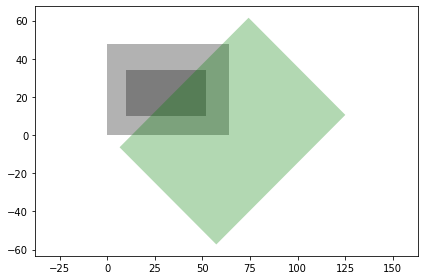

In [8]:
# Draw the view box (green) 
# relative to the full data (gray) 
# and sliced subset (dark gray)

figure()
gca().add_collection(PatchCollection([
    Rectangle((0,0),64,48),
    Rectangle((10,10),42,24),
    Polygon(box_data)
],alpha=0.3,facecolors=['k','k','g']))
axis('equal')
tight_layout()


You can see that the green box intersects the grey ones non-orthogonally.

However, the textures returned from the data sources (grey boxes) should be axis aligned.  They should also cover the visible area (gray intersection with green). What regions should be copied to texture?

There are lots of good choices here. One way to do it is to find the intersection between these simple, convex polygons and then determine the minimal axis-aligned bounding box around that.

Lets do something sillier, and pretend our data is chunked. This corresponds to picking a fixed texture size.  It's silly here because our chunk size is going to be very small. We'll only return the chunks that intersect the green area.

We'll need an intersection test:

In [9]:
def hit(P,r):
    def left_of(p,q,r):
        return cross(q-p,r-p)>0
    return all(left_of(P[p],P[q],r) for (p,q) in zip([0,1,2,3],[1,2,3,0]))

# Test
print(hit(box_data,array([10,10]))) # miss
print(hit(box_data,array([52,10]))) # hit
print(hit(box_data,array([52,34]))) # miss
print(hit(box_data,array([10,34]))) # miss

False
True
True
False


Now to query for intersecting chunks. We'll use the `Data.slice` method we've already defined to return a separate data source for each chunk.

In [10]:
def query_chunks_2d(data_source,query_polygon,cx=8,cy=8):
    shape=data_source._data.shape
    for y in range(0,shape[0],cy):
        for x in range(0,shape[1],cx):
            corners=array([[x,y],[x+cx,y+cy]]).T
            vs=corners_to_box(corners)
            if any(map(lambda v:hit(query_polygon,v),vs)):
                yield data.slice((y,x,0),(y+cy,x+cx,3),(1,1,1))

In [11]:
# Test
list(query_chunks_2d(data1,box_data,cx=8,cy=8))

Note that when we called `Data.slice()` we needed to specify the chunk using the dimensionality of the data - we had to decide what to do with z. We'll have to come back to that. For now, we just decide to use the top z-plane of the data.

Before we dig into that, lets finish copying to "textures" and rendering something.

In [24]:
list(map(
    lambda ds: Tex2d.from_data_source(ds,Tdv), # FIXME: dims here are important - projection to view space. correspondence to gl
    query_chunks_2d(data1,box_data,cx=8,cy=8)
))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

[[ 1.  0.  0.]
 [ 0.  1. -8.]
 [ 0.  0.  0.]
 [ 0.  0.  1.]]
[[  1.   0.   0.]
 [  0.   1. -16.]
 [  0.   0.   0.]
 [  0.   0.   1.]]
[[  1.   0.  -8.]
 [  0.   1. -16.]
 [  0.   0.   0.]
 [  0.   0.   1.]]


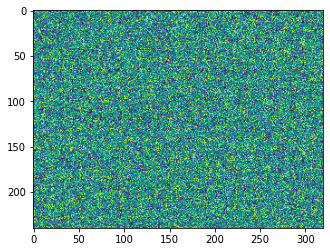

In [21]:
textures=map(Tex2d.from_data_source,query_chunks_2d(data1,box_data,cx=8,cy=8))
imshow(render(View(320,240),textures))